## 使用 CNN 训练 fashion_mnist 数据集

上一节只要是介绍了 CNN 的基本流程和一些概念，这一节就是具体的 CNN 实践，用到的是 Fashion MNIST 数据集。

In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

### Fashion MNIST 数据集

不同于 MNIST 手写数据集，Fashion MNIST 数据集包含了 10 个类别的图像，分别是：

标签 | 类别
-----|-----
0|t-shirt（T恤）
1|trouser（牛仔裤）
2|pullover（套衫）
3|dress（裙子）
4|coat（外套）
5|sandal（凉鞋）
6|shirt（衬衫）
7|sneaker（运动鞋）
8|bag（包）
9|ankle boot（短靴）



+ 训练数据集每个类别含有 6000 个样本，10 个类别共 60000 个样本
+ 测试数据集每个类别含有 1000 个样本，10 个类别共 10000 个样本

图像为 $28\times28$ 单通道灰度图，像素值为 $0\sim255$ 之间的 8 位无符号整数（uint8）。

In [2]:
fashion_mnist = tf.keras.datasets.fashion_mnist

In [3]:
(x_train, y_train), (x_test, y_test) = fashion_mnist.load_data()

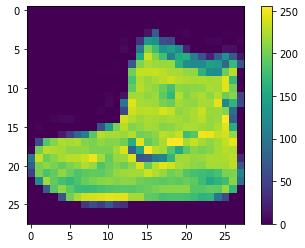

In [4]:
plt.imshow(x_train[0])
plt.colorbar()
plt.show()

In [5]:
y_train[0]

9

In [6]:
x_train.shape

(60000, 28, 28)

In [7]:
y_train.shape

(60000,)

In [8]:
x_test.shape

(10000, 28, 28)

In [9]:
y_test.shape

(10000,)

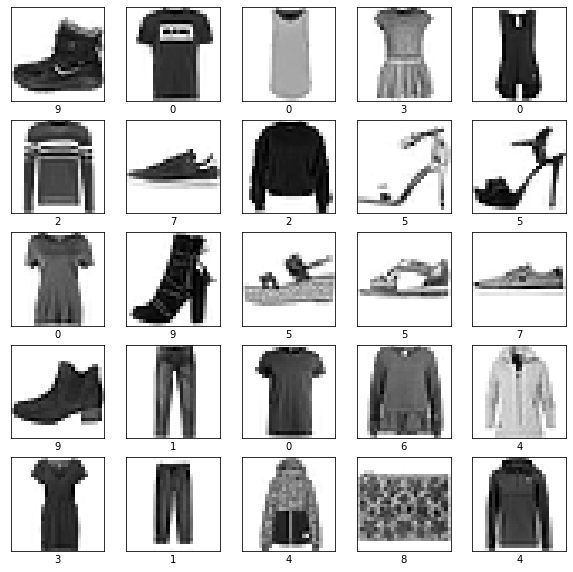

In [10]:
plt.figure(figsize=(10, 10))
for i in range(25):
    plt.subplot(5, 5, i + 1)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(x_train[i], cmap=plt.cm.binary)
    plt.xlabel(y_train[i])
plt.show()

In [11]:
from tensorflow.keras.layers import Conv2D, BatchNormalization, Activation, MaxPool2D, Dropout, Flatten, Dense
import os

### 搭建卷积神经网络

本次用于训练 Fashion MNIST 数据集的网络结构，有三层网络（不算输入层）：一层卷积层和两层全连接层。基本参数如下：

**注** CBAPD 即 **C**onvolutional、**B**atch Normalization、**A**ctivation、**P**ooling、**D**ropout

 + 第一层：卷积层
  + C：使用 6 个 $5\times5$ 的卷积核，步长为 1，全 0 填充（same）
  + B：使用批标准化
  + A：使用 ReLu 激活函数
  + P：使用 $2\times2$ 的池化核，采用最大值池化，步长为 2，全 0 填充（same）
  + D：Droput 概率为 0.2
 + Flatten 拉伸卷积层传来的输入特征
 + 第二层：全连接层
  + 128 个神经元
  + 使用 ReLu 激活函数
  + Dropout 概率为 0.2
 + 第三层：全连接层（输出层）
  + 10 个神经元
  + 使用 softmax 激活函数
  
本次实现的是 CNN 的 baseline 版本，后续会在该 baseline 版本的基础上不断改进网络结构。此外，因为是简单的线性结构，所以直接使用 Sequential 来构建，往后涉及非线性的网络结构时，会继承 Model 类来自定义网络结构。

In [12]:
baseline = [
    Conv2D(filters=6, kernel_size=(5, 5), padding='same'),
    BatchNormalization(),
    Activation('relu'),
    MaxPool2D(pool_size=(2, 2), strides=2, padding='same'),
    Dropout(0.2),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.2),
    Dense(10, activation='softmax')
]

基于之前“六步法”搭建神经网络的经验，逐步写出代码：

In [13]:
# 归一化
x_train, x_test = x_train / 255.0, x_test / 255.0
# 给数据增加一个维度，使数据和网络结构匹配
x_train = x_train.reshape(x_train.shape[0], 28, 28, 1)
x_test = x_test.reshape(x_test.shape[0], 28, 28, 1)

In [14]:
model = tf.keras.models.Sequential(baseline)

In [15]:
# 配置模型参数
model.compile(optimizer='adam', 
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False), 
              metrics=['sparse_categorical_accuracy'])

In [16]:
# 设置断点续训
checkpoint_save_path = './checkpoint/Baseline.ckpt'
if os.path.exists(checkpoint_save_path + '.index'):
    model.load_weights(checkpoint_save_path)

In [17]:
# 设置保存最优模型参数回调
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_save_path,
                                                save_weights_only=True,
                                                save_best_only=True)

In [18]:
# 训练模型
history = model.fit(x_train, y_train,
                   batch_size=128,
                   epochs=5,
                   validation_data=(x_test, y_test),
                   validation_freq=1,
                   callbacks=[cp_callback])

Train on 60000 samples, validate on 10000 samples
Epoch 1/5
60000/60000 [==============================] - 35s 592us/sample - loss: 0.2473 - sparse_categorical_accuracy: 0.9080 - val_loss: 0.2679 - val_sparse_categorical_accuracy: 0.9014
Epoch 2/5
60000/60000 [==============================] - 33s 557us/sample - loss: 0.2432 - sparse_categorical_accuracy: 0.9085 - val_loss: 0.2679 - val_sparse_categorical_accuracy: 0.9032
Epoch 3/5
60000/60000 [==============================] - 34s 562us/sample - loss: 0.2398 - sparse_categorical_accuracy: 0.9104 - val_loss: 0.2612 - val_sparse_categorical_accuracy: 0.9038
Epoch 4/5
60000/60000 [==============================] - 33s 549us/sample - loss: 0.2380 - sparse_categorical_accuracy: 0.9100 - val_loss: 0.2740 - val_sparse_categorical_accuracy: 0.9031
Epoch 5/5
60000/60000 [==============================] - 33s 555us/sample - loss: 0.2338 - sparse_categorical_accuracy: 0.9143 - val_loss: 0.2666 - val_sparse_categorical_accuracy: 0.9056


In [19]:
# 打印网络结构
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              multiple                  156       
_________________________________________________________________
batch_normalization (BatchNo multiple                  24        
_________________________________________________________________
activation (Activation)      multiple                  0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) multiple                  0         
_________________________________________________________________
dropout (Dropout)            multiple                  0         
_________________________________________________________________
flatten (Flatten)            multiple                  0         
_________________________________________________________________
dense (Dense)                multiple                  1

In [20]:
np.set_printoptions(threshold=np.inf)
# 保存参数信息
with open('./data/weights.txt', 'w') as file:
    for v in model.trainable_variables:
        file.write(str(v.name) + '\n')
        file.write(str(v.shape) + '\n')
        file.write(str(v.numpy()) + '\n')

In [21]:
# 获取 acc 和 loss 曲线数据
acc = history.history['sparse_categorical_accuracy']
val_acc = history.history['val_sparse_categorical_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

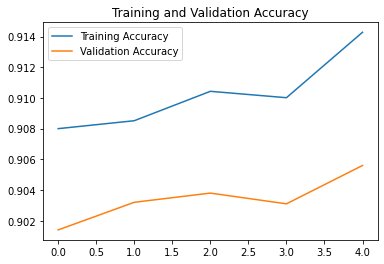

In [22]:
# 可视化 acc 曲线
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.show()

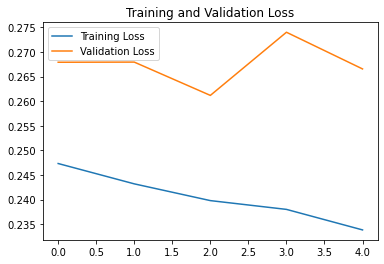

In [23]:
# 可视化 loss 曲线
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()